# Andel af Hospitaliseringer (non age corrected)

Find en forskydning mellem hospitaliseringer og antal positive på en dag, ved at analysere peaket omkring jul. Antal dage imellem peaket svarer altså til det antal dage der går fra du konstanteres smittes til en andel indlægges. Andelen findes til sidst ved antal hospitaliseringer (for forskydningen af dage frem) divideret med antal positive for dagen. Antallet af positive som bliver indlagt forventes umiddelbart at være konstant, dog er vi begyndt at vaccinere så langsomt bør vi kunne begynde at se andelen blive mindre.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import scipy 
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit

In [2]:
mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")

# Indlæs data

In [246]:
folder = 'Data-Epidemiologiske-Rapport-16042021-10uu'

data_døde = pd.read_csv(folder + "/Deaths_over_time.csv", sep=';', thousands='.', index_col=0)
data_hospital = pd.read_csv(folder + "/Newly_admitted_over_time.csv", sep=';', thousands='.', index_col=0)
data_posi = pd.read_csv(folder + "/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)
#data_vacc = pd.read_csv('Vaccine_DB/FaerdigVacc_daekning_DK_prdag.csv', sep=',', thousands='.', index_col=0)

fit_to_latest = True

# Print how much data is included:
date_start = "2020-08-31"
if fit_to_latest :
    date_end = data_hospital.index[-3]  # Omitting the very latest data point (with ~0 statistics)
else :
    date_end = "2021-04-16"          # Value in latest report files
print("  Data used: ", date_start, "-", date_end)    

# Hospitalisations per day
H_all = data_hospital.loc[date_start:date_end]['Total']
eH_all = np.sqrt(H_all)

# Deaths per day
D_all = data_døde.loc[date_start:date_end]['Antal_døde']
eD_all = np.sqrt(D_all)

# Number of positives per days
P_all = data_posi.loc[date_start:date_end].sum(axis=1)
eP_all = np.sqrt(P_all)

# Array with times
Plot_startday = 0
Plot_endday = len(H_all)
days = np.arange(Plot_startday, Plot_endday)

  Data used:  2020-08-31 - 2021-04-13


# Plot hospitaliseringer og positive test - find forskydning ved at fitte gauss

Text(0, 0.5, 'Antal positive')

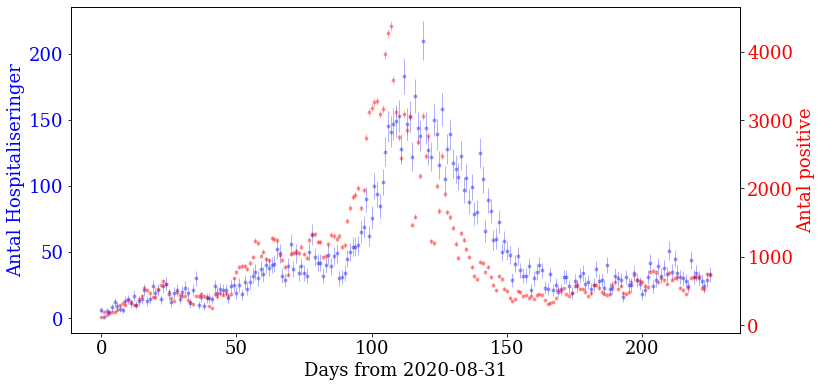

In [22]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx() 
ax2.errorbar(days, P_all, yerr=eP_all, fmt='.', linewidth=1, label='Antal positive', color='red', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xlabel(f'Days from {date_start}')
ax1.set_ylabel('Antal Hospitaliseringer', color='blue')
ax2.set_ylabel('Antal positive', color='red')

In [28]:
# Fit med en gauss på en lineær baggrund?

# Definer fit funktion
def gauss_plus_lin(x, N, mu, sigma, a, b):
    
    gauss = N * stats.norm.pdf(x, mu, sigma)
    
    lin = a*x + b
    
    return gauss + lin

# Definer chi2 udreging
def chi2_H(N, mu, sigma, a, b):
    
    y_fit = gauss_plus_lin(days, N, mu, sigma, a, b)
    chi2 = np.sum( ((H_all - y_fit) / eH_all)**2 )

    return chi2

def chi2_P(N, mu, sigma, a, b):
    
    y_fit = gauss_plus_lin(days, N, mu, sigma, a, b)
    chi2 = np.sum( ((P_all - y_fit) / eP_all)**2 )

    return chi2

# Fit the hospitalisations
minuit_H = Minuit(chi2_H, N=np.sum(H_all), mu=110, sigma=15, a=-2, b=50, print_level=1, errordef=1.0)
minuit_H.migrad(); 

# Fit the positives
minuit_P = Minuit(chi2_P, N=np.sum(P_all), mu=105, sigma=5, a=-2, b=70, print_level=1, errordef=1.0)
minuit_P.migrad(); 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 786.9                      │        Nfcn = 423 (423 total)        │
│ EDM = 9.72e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.815e+04                  │        Nfcn = 173 (173 total)        │
│ EDM = 5.05e-06 (Goal: 0.0002)    │                                      │
├───────────

Text(0, 0.5, 'Antal positive')

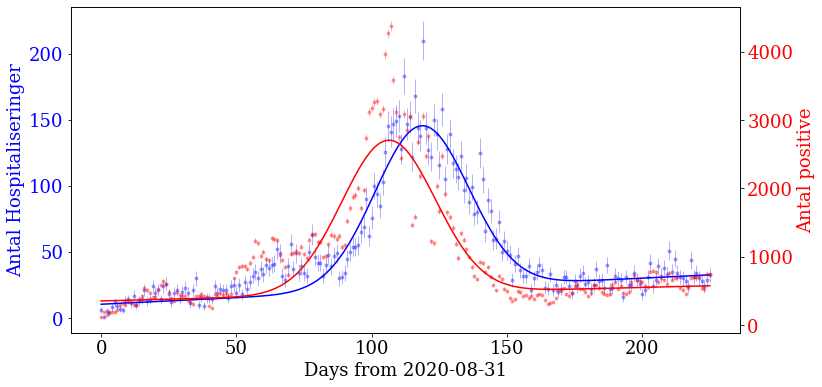

In [29]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Hospitalisations plot
ax1.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

# Hospitalisations fit
ax1.plot(days, gauss_plus_lin(days, *minuit_H.args), color='blue')

# Positives plot
ax2 = ax1.twinx() 
ax2.errorbar(days, P_all, yerr=eP_all, fmt='.', linewidth=1, label='Antal positive', color='red', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='red')

# Positives fit
ax2.plot(days, gauss_plus_lin(days, *minuit_P.args), color='red')

ax1.set_xlabel(f'Days from {date_start}')
ax1.set_ylabel('Antal Hospitaliseringer', color='blue')
ax2.set_ylabel('Antal positive', color='red')

In [30]:
# What is the shift between the two peaks
H_shift = minuit_H.values['mu'] - minuit_P.values['mu']
eH_shift = minuit_H.errors['mu'] + minuit_P.errors['mu']
print(f'{ H_shift } +/- {eH_shift}' )

12.260180450216296 +/- 0.39595747189917546


# Plot døde og hospitaliseringer - find forskydning ved at fitte gauss

Text(0, 0.5, 'Antal døde')

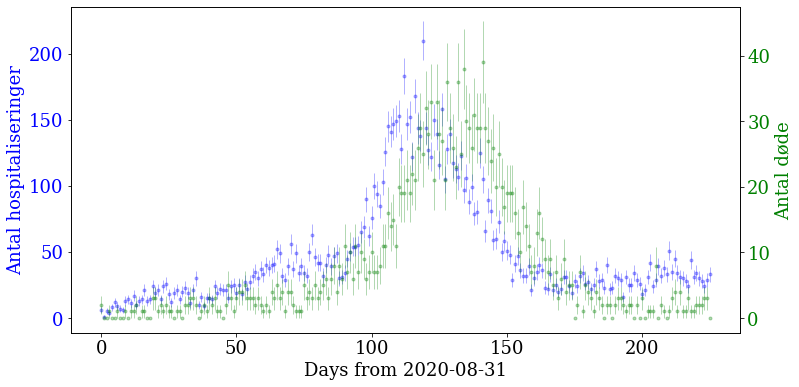

In [31]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx() 
ax2.errorbar(days, D_all, yerr=eD_all, fmt='.', linewidth=1, label='Antal døde', color='green', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='green')

ax1.set_xlabel(f'Days from {date_start}')
ax1.set_ylabel('Antal hospitaliseringer', color='blue')
ax2.set_ylabel('Antal døde', color='green')

In [51]:
# Fit med en gauss på en lineær baggrund?

# Definer chi2 udreging for døde
def chi2_D(N, mu, sigma, a, b):
    
    y_fit = gauss_plus_lin(days, N, mu, sigma, a, b)
    chi2 = np.sum( ((D_all - y_fit) / eD_all)**2 )

    return chi2

# Fit the hospitalisations
minuit_H = Minuit(chi2_H, N=np.sum(H_all), mu=110, sigma=15, a=0.1, b=50, print_level=1, errordef=1.0)
minuit_H.migrad(); 

# Fit the positives
minuit_D = Minuit(chi2_D, N=np.sum(D_all), mu=130, sigma=20, a=0, b=0, print_level=1, errordef=1.0)
minuit_D.migrad();

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 786.9                      │        Nfcn = 137 (137 total)        │
│ EDM = 0.000107 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = inf                        │        Nfcn = 123 (123 total)        │
│ EDM = nan (Goal: 0.0002)         │                                      │
├───────────

Text(0, 0.5, 'Antal døde')

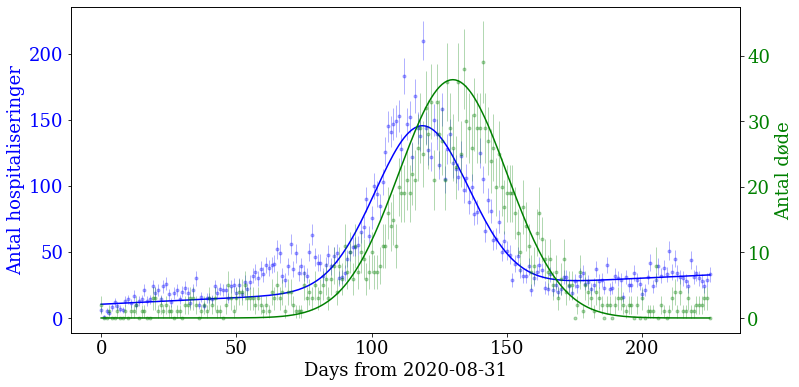

In [52]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Hospitalisations plot
ax1.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

# Hospitalisations fit
ax1.plot(days, gauss_plus_lin(days, *minuit_H.args), color='blue')

# Deaths plot
ax2 = ax1.twinx() 
ax2.errorbar(days, D_all, yerr=eD_all, fmt='.', linewidth=1, label='Antal døde', color='green', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='green')

# Positives fit
ax2.plot(days, gauss_plus_lin(days, *minuit_D.args), color='green')

ax1.set_xlabel(f'Days from {date_start}')
ax1.set_ylabel('Antal hospitaliseringer', color='blue')
ax2.set_ylabel('Antal døde', color='green')

In [53]:
# What is the shift between the two peaks
D_shift = minuit_D.values['mu'] - minuit_H.values['mu']
eD_shift = minuit_D.errors['mu'] + minuit_H.errors['mu']
print(f'{ D_shift } +/- {eD_shift}' )

11.475784611364276 +/- nan


# Andel af Hospitaliseringer pr dag. (med forskydning)

antal indlagte / antal positibe per dag, vi skal nok have forskydningen med. denne ratio skal være nogenlunde konstant men dalende pga vaccinationer.

Text(0, 0.5, 'Fraction of hospitalisations. \n H(12 days ahead)/P(now)')

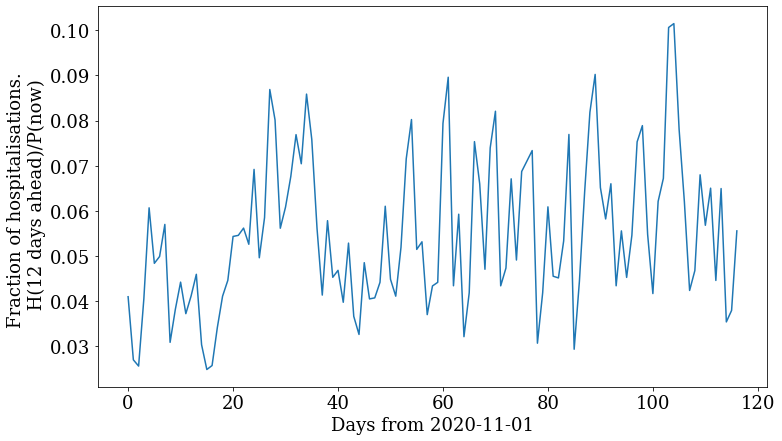

In [44]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot( days[:-12], [i/j for i,j in zip(H_all[12:], P_all[:-12]) ] )

ax.set_xlabel(f'Days from {date_start}')
ax.set_ylabel('Fraction of hospitalisations. \n H(12 days ahead)/P(now)')

Perhaps we should do this with the scaled positives instead?

# Different graphs showing SP, Hospitalisations and Deaths

## Plot 1: Scaled Positives, Hospitaliseringer og Døde (DAILY)

Text(0.5, 0, 'Days from 2020-08-31')

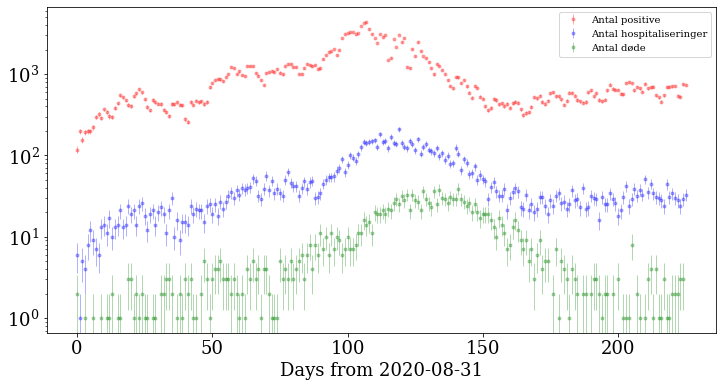

In [58]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot raw data 
ax.errorbar(days, P_all, yerr=eP_all, fmt='.', linewidth=1, label='Antal positive', color='red', alpha=0.3)
ax.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax.errorbar(days, D_all, yerr=eD_all, fmt='.', linewidth=1, label='Antal døde', color='green', alpha=0.3)

ax.set_yscale('log')
ax.legend(prop={'size': 10})
ax.set_xlabel(f'Days from {date_start}')

Der er måske noget galt med errors på døde her - vi kan nok ikke bruge poisson errors på så små tal. det er derfor vi gerne vil gøre det weekly.

## Plot 2: Alligned plot med Scaled positives, hospitaliseringer og døde (DAILY)

In [56]:
#Vi skal bruge forskydningerne
print('Hospitaliserings forskydning fra SP:', H_shift, '+/-', eH_shift)
print('Døde forskydning fra hospitaliseringer:', D_shift, '+/-', eD_shift)

Hospitaliserings forskydning fra SP: 12.260180450216296 +/- 0.39595747189917546
Døde forskydning fra hospitaliseringer: 11.475784611364276 +/- nan


In [61]:
# Vi skal bruge en diskret værdi
H_sh = int(np.round(H_shift))
D_sh = int(np.round(D_shift))

# total shift
tot_sh = H_sh + D_sh

print(H_sh, D_sh)

12 11


In [128]:
# Lad os nu lave vores alligned array, det betyder at vi må skære 12+11 datapunkter fra hver ende.

P_alligned = P_all.iloc[:-tot_sh] #iloc for at bruge index nummer
eP_alligned = eP_all.iloc[:-tot_sh]

H_alligned = H_all.iloc[H_sh:-D_sh]
eH_alligned = eH_all.iloc[H_sh:-D_sh]

D_alligned = D_all.iloc[tot_sh:]
eD_alligned = eD_all.iloc[tot_sh:]

days_alligned = days[:-tot_sh]

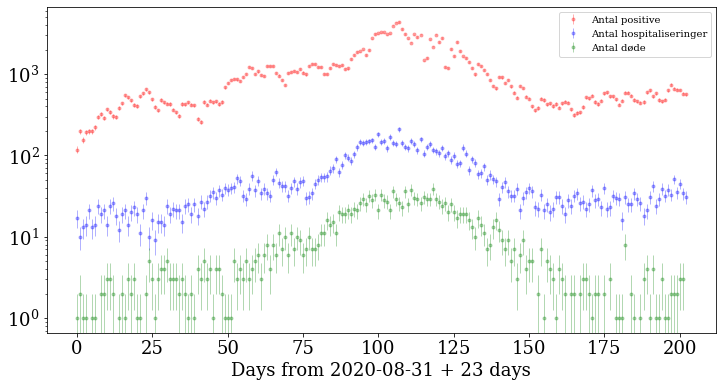

In [129]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot alligned data 
ax.errorbar(days_alligned, P_alligned, yerr=eP_alligned, fmt='.', linewidth=1, label='Antal positive', color='red', alpha=0.3)
ax.errorbar(days_alligned, H_alligned, yerr=eH_alligned, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax.errorbar(days_alligned, D_alligned, yerr=eD_alligned, fmt='.', linewidth=1, label='Antal døde', color='green', alpha=0.3)

ax.set_yscale('log')
ax.legend(prop={'size': 10})
ax.set_xlabel(f'Days from {date_start} + {tot_sh} days')

plt.show()

## Plot 3: Ratio plot (DAILY)

Vi vil plotte fra de alligned arrays: hospitaliseringer/positives, døde/positives og døde/hospitaliseringer.

In [140]:
# First lets get the ratios as arrays
H_by_P = [i/j for i,j in zip(H_alligned, P_alligned)]
D_by_P = [i/j for i,j in zip(D_alligned, P_alligned)]
D_by_H = [i/j for i,j in zip(D_alligned, H_alligned)]

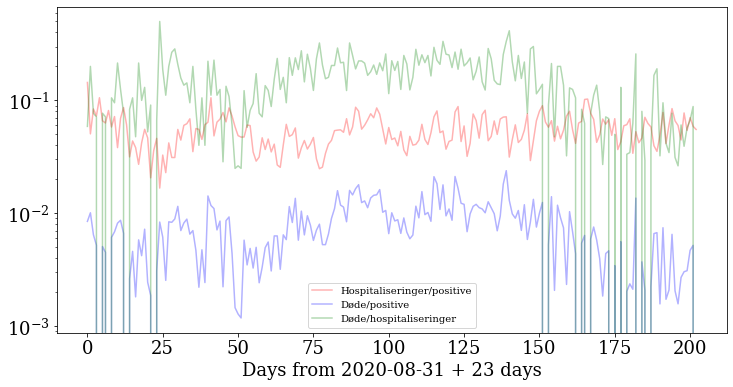

In [144]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot ratios 
ax.plot(days_alligned, H_by_P, label='Hospitaliseringer/positive', color='red', alpha=0.3)
ax.plot(days_alligned, D_by_P, label='Døde/positive', color='blue', alpha=0.3)
ax.plot(days_alligned, D_by_H, label='Døde/hospitaliseringer', color='green', alpha=0.3)

ax.set_yscale('log')
ax.legend(prop={'size': 10})
ax.set_xlabel(f'Days from {date_start} + {tot_sh} days')

plt.show()

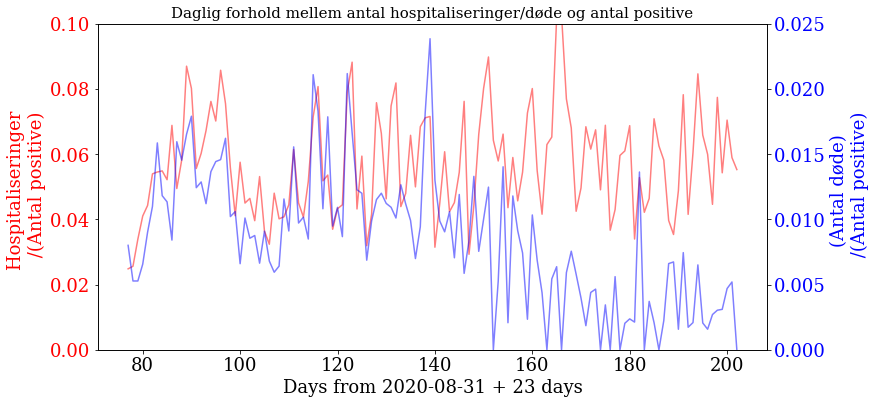

In [383]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot ratios 
ax.plot(days_alligned[77:], H_by_P[77:], label='Hospitaliseringer/positive', color='red', alpha=0.5)
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel('Hospitaliseringer \n /(Antal positive)', color='red')
ax.set_ylim(0,0.1)

ax2 = ax.twinx() 
ax2.plot(days_alligned[77:], D_by_P[77:], label='Døde/positive', color='blue', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylabel('(Antal døde) \n /(Antal positive)', color='blue')
ax2.set_ylim(0,0.025)

#ax.legend(prop={'size': 10})
ax.set_xlabel(f'Days from {date_start} + {tot_sh} days')
ax.set_title('Daglig forhold mellem antal hospitaliseringer/døde og antal positive', size=15)
plt.show()

this one, men som twin axis lineær skala og weekly!!! og dato på skrå

## Plot 2: Scaled Positives, Hospitaliseringer og Døde (Weekly)

Vi lader antal positive bestemme hvordan vi inddeler ugerne dvs vi først aligner dem og så inddeler dem efter det. Jeg har valgt den 31 august da dette er en mandag, vi kan da lave et nyt array som indeholder de summede tal for en uge af gangen.

In [278]:
# Find ugentlige data (de er alle alligned)
index = np.arange(0, len(P_alligned)//7 * 7, 7)

P_weekly = []
eP_weekly = []

H_weekly = []
eH_weekly = []

D_weekly = []
eD_weekly = []

for i in index:
    P_temp = np.sum(P_alligned.iloc[i:i+7])
    H_temp = np.sum(H_alligned.iloc[i:i+7])
    D_temp = np.sum(D_alligned.iloc[i:i+7])
    
    eP_temp = np.sqrt(P_temp)
    eH_temp = np.sqrt(H_temp)
    eD_temp = np.sqrt(D_temp)
    
    P_weekly.append(P_temp)
    eP_weekly.append(eP_temp)
    
    H_weekly.append(H_temp)
    eH_weekly.append(eH_temp)
    
    D_weekly.append(D_temp)
    eD_weekly.append(eD_temp)
    
weeks = np.arange(0, len(P_weekly))

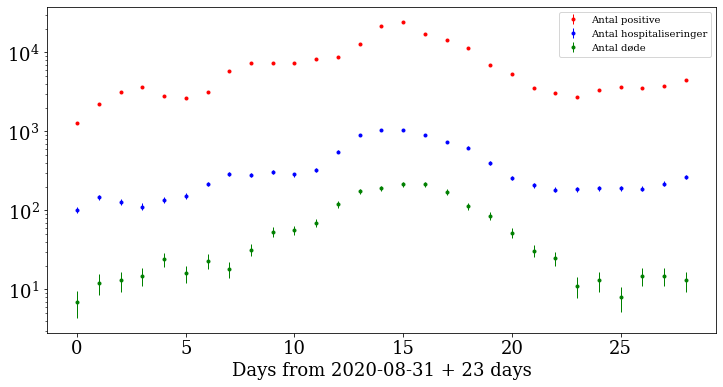

In [279]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot alligned data weekly
ax.errorbar(weeks, P_weekly, yerr=eP_weekly, fmt='.', linewidth=1, label='Antal positive', color='red')
ax.errorbar(weeks, H_weekly, yerr=eH_weekly, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue')
ax.errorbar(weeks, D_weekly, yerr=eD_weekly, fmt='.', linewidth=1, label='Antal døde', color='green')

ax.set_yscale('log')
ax.legend(prop={'size': 10})
ax.set_xlabel(f'Days from {date_start} + {tot_sh} days')

plt.show()

## Plot 3: ratio plot (WEEKLY)

In [374]:
# First lets get the ratios as arrays
H_by_P_weekly = [i/j for i,j in zip(H_weekly, P_weekly)]
D_by_P_weekly = [i/j for i,j in zip(D_weekly, P_weekly)]
D_by_H_weekly = [i/j for i,j in zip(D_weekly, H_weekly)]

# Errors on the ratios
def ratio_err(f, x, ex, y, ey): #helper function for error propagation of ratio
    ef = f * np.sqrt( (ex/x)**2 + (ey/y)**2 )
    return ef

eH_by_P_weekly = [ratio_err(H_by_P_weekly[i], H_weekly[i], eH_weekly[i], P_weekly[i], eP_weekly[i]) for i in range(len(P_weekly))]
eD_by_P_weekly = [ratio_err(D_by_P_weekly[i], D_weekly[i], eD_weekly[i], P_weekly[i], eP_weekly[i]) for i in range(len(P_weekly))]
eD_by_H_weekly = [ratio_err(D_by_H_weekly[i], D_weekly[i], eD_weekly[i], H_weekly[i], eH_weekly[i]) for i in range(len(P_weekly))]

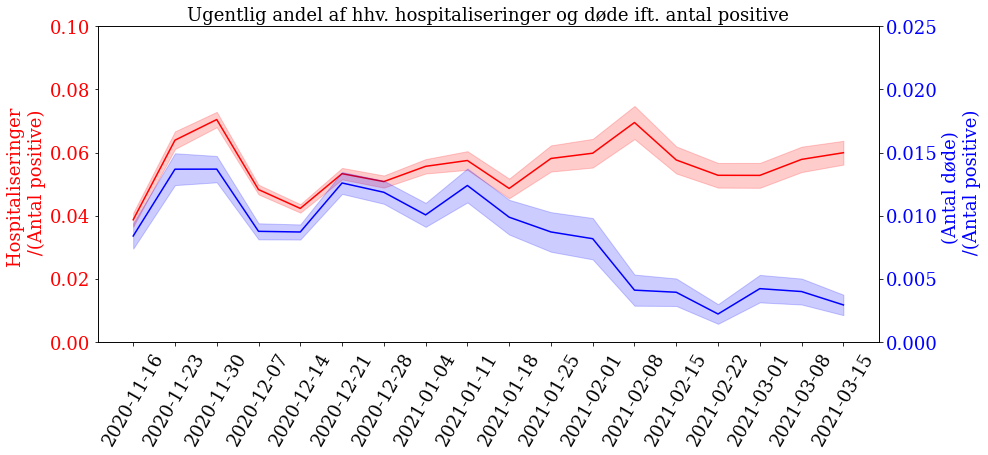

In [382]:
fig, ax = plt.subplots(figsize=(14,6))

# Plot H/P ratio
ax.plot(weeks[11:], H_by_P_weekly[11:], label='Hospitaliseringer/positive', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel('Hospitaliseringer \n /(Antal positive)', color='red')
ax.set_ylim(0,0.1)

#mark errors
HP_low = [i-j for i,j in zip(H_by_P_weekly[11:], eH_by_P_weekly[11:])]
HP_high = [i+j for i,j in zip(H_by_P_weekly[11:], eH_by_P_weekly[11:])]
ax.fill_between(x=weeks[11:], y1=HP_low, y2=HP_high, color='red', alpha=0.2)


# Plot D/P on separate axis
ax2 = ax.twinx() 
ax2.plot(weeks[11:], D_by_P_weekly[11:], label='Døde/positive', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylabel('(Antal døde) \n /(Antal positive)', color='blue')
ax2.set_ylim(0,0.025)

#mark errors
DP_low = [i-j for i,j in zip(D_by_P_weekly[11:], eD_by_P_weekly[11:])]
DP_high = [i+j for i,j in zip(D_by_P_weekly[11:], eD_by_P_weekly[11:])]
ax2.fill_between(x=weeks[11:], y1=DP_low, y2=DP_high, color='blue', alpha=0.2)


# Make nice xticks showing the week day ---------------------------------------

mon_dates = P_alligned.iloc[0:-1:7].index # get the dates of each monday of the week for entire period

ax.set_xticks( [*weeks[11:]] ) # Set locations
ax.set_xticklabels( mon_dates[11:], rotation=60, rotation_mode='default') #, rotation=40 ) # set labels

# ------------------------------------------------------------------------------

ax.set_title('Ugentlig andel af hhv. hospitaliseringer og døde ift. antal positive', size=18)
plt.subplots_adjust(bottom=0.15)
plt.show()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 202.9                      │         Nfcn = 11 (11 total)         │
│ EDM = 1.1e-16 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 52.92                      │        Nfcn = 298 (298 total)        │
│ EDM = 3.22e-05 (Goal: 0.0002)    │                                      │
├───────────

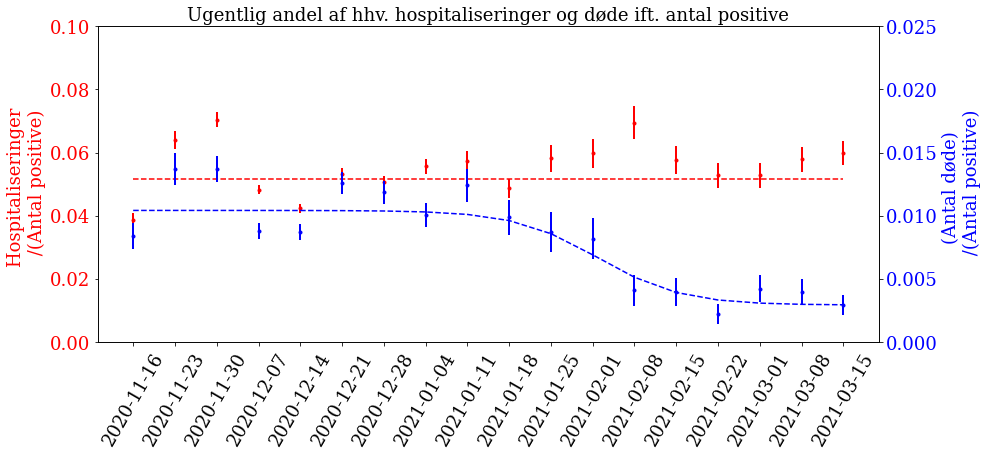

In [439]:
fig, ax = plt.subplots(figsize=(14,6))

# Plot H/P ratio
ax.errorbar(weeks[11:], H_by_P_weekly[11:], yerr=eH_by_P_weekly[11:], fmt='.', linewidth=2, label='Hospitaliseringer/positive', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel('Hospitaliseringer \n /(Antal positive)', color='red')
ax.set_ylim(0,0.1)

# Plot D/P on separate axis
ax2 = ax.twinx() 
ax2.errorbar(weeks[11:], D_by_P_weekly[11:], yerr=eD_by_P_weekly[11:], fmt='.', linewidth=2, label='Døde/positive', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylabel('(Antal døde) \n /(Antal positive)', color='blue')
ax2.set_ylim(0,0.025)

# Fitting a straight line thorugh hospitalisation data ---------------------------
def constant_fit(x, k):
    return np.ones_like(x) * k

def chi2_straight(k):
    y_fit = constant_fit(weeks[11:], k)
    chi2 = np.sum( ((H_by_P_weekly[11:] - y_fit)/eH_by_P_weekly[11:])**2 )
    return chi2

minuit_straight = Minuit(chi2_straight, k=0.06, print_level=1, errordef=1.0)
minuit_straight.migrad(); 

ax.plot(weeks[11:], constant_fit(weeks[11:], *minuit_straight.args), color='red', linestyle='dashed')
# ------------------------------------------------------------------------------

# fitting a sigmoid to deaths ---------------------------------------------
def sigmoid_fit(x, A, B, C):
    return A / (1 + 1*np.exp(-(x-B))) + C

def chi2_sigmoid(A, B, C):
    y_fit = sigmoid_fit(weeks[11:], A, B, C)
    chi2 = np.sum( ((D_by_P_weekly[11:] - y_fit)/eD_by_P_weekly[11:])**2 )
    return chi2

minuit_sigmoid = Minuit(chi2_sigmoid, A=-0.2, B=21, C=0.08, print_level=1, errordef=1.0)
minuit_sigmoid.migrad(); 

ax2.plot(weeks[11:], sigmoid_fit(weeks[11:], *minuit_sigmoid.args), color='blue', linestyle='dashed')

# ------------------------------------------------------------------------------

# Make nice xticks showing the week day ---------------------------------------
mon_dates = P_alligned.iloc[0:-1:7].index # get the dates of each monday of the week for entire period

ax.set_xticks( [*weeks[11:]] ) # Set locations
ax.set_xticklabels( mon_dates[11:], rotation=60, rotation_mode='default') # set labels
# ------------------------------------------------------------------------------

# marker ferier -----------------------------------


ax.set_title('Ugentlig andel af hhv. hospitaliseringer og døde ift. antal positive', size=18)
plt.subplots_adjust(bottom=0.15)
plt.show()